# Tag 1 - Einführung in Machine Learning
### Was wir heute lernen werden
In den Übungen in diesem Notebook werden wir die Grundlagen von Machine Learning, insbesondere Deep Learning, mit der Library PyTorch lernen. Dazu verwenden wir einen klassischen ML Use-Case: Klassifizierung von Bildern. Im Detail werden wir die folgenden Punkte behandeln:
- Daten & Pre-Processing:
  - Wie werden Bild-Daten für ML Zwecke repräsentiert?
  - Wie laden wir unsere Daten effizient, und wie teilen wir sie in Trainings-/Validierungs-/Test-Daten auf?
  - Welche Pre-Processing Schritte müssen wir anwenden, um unsere Daten nutzen zu können?
- Model-Konstruktion:
  - Warum sind Convolutional Neural Networks (CNNs) eine beliebte Architektur für Bilder als Input-Daten?
  - Wie ist ein Convolutional Neural Network (CNN) aufgebaut? Welcher Layer tut was? 
  - Wie konstruiere ich mein eigenes CNN?
- Training:
  - Was passiert beim Training eines Neural Networks? Was ist Back-Propagation? 
  - Wie ist der Trainings-Loop eines ML Models aufgebaut? 
  - Was ist eine Loss-Function? Wofür brauche ich einen Optimizer?
  - Wie bestimme ich, ob sich mein Model durch das Training verbessert?
- Overfitting:
  - Was ist Overfitting? Woran erkenne ich es?
  - Welche Möglichkeiten habe ich, um damit umzugehen (Data Augmentation, Regularization, etc.)?
- Transfer-Learning
  - Wie kann ich bereits trainierte Models nutzen, um schneller zu einem Model für meinen Use-Case zu kommen?
- Inferenz:
  - Wie nutze ich mein trainiertes Model?

### Was wir heute bauen werden
In der heutigen Einheit bauen wir einen Classifier, der zwischen zwei Klassen unterscheiden kann: Katzen und Hunde! Am Ende werden wir ein kleines Interface bauen, in dem du Bilder deines eigenen Haustiers hochladen kannst, um zu testen, ob der Classifier sie richtig einordnen kann:  

## Daten & Pre-Processing
### Datensatz

Bevor wir überhaupt daran denken, unser Model zu trainieren, brauchen wir die Daten mit dem wir es trainieren können. Für unseren Zweck gibt es den [Cats-vs-Dogs Datensatz](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset), der aus dem Bilder-Korpus für Microsofts Asirra CAPTCHAs entstanden ist: https://www.microsoft.com/en-us/research/publication/asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization/. Füge den Datensatz deinem Jupyter Notebook hinzu, in dem du in der rechten Seitenleiste unter dem "Data"-Reiter auf "Add Data" klickst: 

<img style="width: 300px; height: auto;" src=" 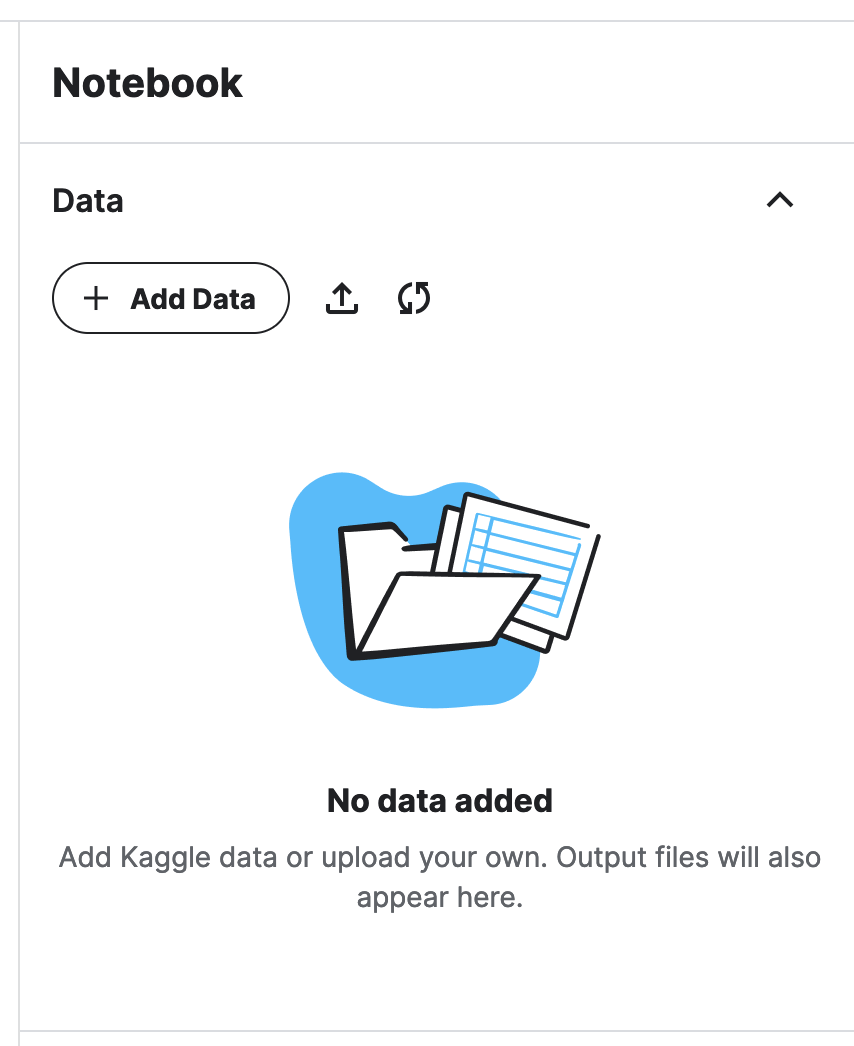">

Suche hier nach "Cats-vs-Dogs" und füge den Datensatz mit einem Klick auf den "+"-Button deinem Environment hinzu: 

<img style="width: 300px; height: auto;" src=" 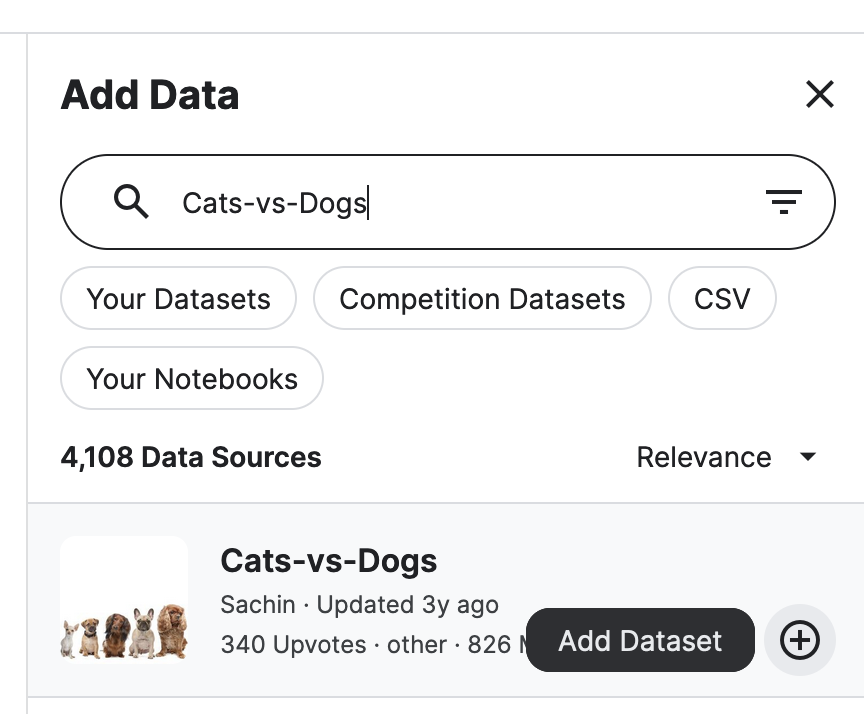">

In der Seitenleiste kannst du jetzt die Struktur des heruntergeladenen Datensatzes begutachten: Wir haben einen Ordner `PetImages`, in dem zwei Ordner `Cats` und `Dogs` liegen. Jeder dieser Ordner enthält 12.500 `.jpg`-Bilder, die jeweils Katzen oder Hunde zeigen. Im Datei-System deines Kaggle-Notebooks wurde der Datensatz unter `/kaggle/input/microsoft-catsvsdogs-dataset` abgelegt.

<span style="color:white; background-color: blue; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Info: </span> Das Laden von Datensätzen über diesen Mechanismus ist eine Einschränkung von Kaggle, da wir von Kaggle keinen uneingeschränkten Zugriff auf das Environment bekommen, in dem unser Jupyter-Notebook läuft. Beim Entwickeln auf deinem eigenen Rechner hättest du selbstverständlich mehr Möglichkeiten, um Daten zu laden: je nach Art der Daten für den aktuellen Use-Case stehen von Downloads von File-Servern über Verteilung mittels Torrents bis zu Exports von Datenbanken viele Wege offen.

### Laden des Datensatzes
PyTorch abstrahiert einen Datensatz mit der `Dataset`-Klasse (https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), die nur 2 Methoden besitzt: `__len__()` gibt die Anzahl der Samples im Datensatz zurück, während `__getitem__()` das Sample zu einem bestimmten Index liefert. Ein Sample besteht hierbei immer aus den Features (also unseren Input-Daten, hier ein Bild) und dem Label (also das, was unser Model als Output produzieren soll, hier `0` oder `1`, je nachdem ob das Input-Bild eine Katze oder einen Hund zeigt). Per Konvention akzeptieren `Dataset`s zwei Constructor-Arguments `transform` und `target_transform`. Mit diesen können wir Funktionen übergeben, die die Features oder das Label verändern, bevor sie von einem Aufruf von `__getitem__()` zurückgegeben werden. 

Laden wir also unseren Datensatz. Der Aufbau unseres Datensatzes eignet sich perfekt für den Einsatz der `ImageFolder` Klasse aus der `torchvision`-Library, einer Sub-Klasse von `Dataset`: https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html. Da diese Bilder standardmäßig als Instanzen der `Image`-Klasse aus der `pillow`-Library lädt (https://pillow.readthedocs.io/en/stable/), übergeben wir die `ToTensor()` Funktion als `transform`, damit wir die Bilddaten von unserem `Dataset` direkt als PyTorch-Tensors geliefert bekommen.

In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor

catsvsdogs_dataset = datasets.ImageFolder("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages", transform=ToTensor())

Sehen wir uns unser `Dataset` an. Wie erwartet enthält es insgesamt 30.000 Samples:

In [ ]:
catsvsdogs_dataset.__len__()

Wenn wir uns mit `__getitem__()` ein bestimmtes Sample zurückgeben lassen, erhalten wir ein Tuple mit 2 Einträgen, die Features (also das Input-Bild) und das Label:

In [7]:
sample_id = 5
sample = catsvsdogs_dataset.__getitem__(sample_id)
print(f"Image Shape: {sample[0].shape}")
print(f"Image Data: {sample[0]}")
print(f"Label: {sample[1]}")

Image Shape: torch.Size([3, 360, 431])
Image Data: tensor([[[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         ...,
         [0.3255, 0.3059, 0.3451,  ..., 0.0863, 0.0941, 0.0902],
         [0.3608, 0.4314, 0.4157,  ..., 0.0667, 0.0667, 0.0667],
         [0.4510, 0.3608, 0.2667,  ..., 0.0706, 0.0706, 0.0706]],

        [[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         ...,
         [0.0824, 0.0784, 0.0863,  ..., 0.0314, 0.0314, 0.0353],
         [0.1176, 0.1647, 0.1569,  ..., 0.0314, 0.0314, 0.0314],
         [0.1804, 0.1176, 0.0157,  ..., 0.0314, 0.0314, 0.0314]],

        [[0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
         [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
       

Das Label ist wie erwartet `0` oder `1` je nach Klasse des Bildes. Das Bild selbst wird uns als 3-dimensionaler PyTorch Tensor zurückgegeben. Diese Dimensionen beschreiben $C \times H \times W$, wobei $H$ und $W$ die Höhe bzw. Breite des Bildes in Pixeln repräsentieren, während $C$ die Anzahl der Farbkanäle darstellt. Für schwarz-weiße Bilder ist $C=1$, während Farbbilder 3 Farbkanäle haben ($C=3$), gewöhnlich in der Reihenfolge Red-Green-Blue (RGB). Wie du an der Ausgabe oben sehen kannst, haben die Farbkanäle Werte von `0-1`.

Um auch tatsächlich zu sehen, welches Bild wir hier geladen haben, können wir die `imshow`-Funktion der `matplotlib`-Library verwenden. Die Funktion akzeptiert sowohl Werte von `0-255` als auch von `0-1` für die 3 Farbkanäle jedes Pixels. `matplotlib` erwartet Bilddaten aber im $H \times W \times C$ Format, weswegen wir die Dimensionen unseres Tensors mit der `permute()` Funktion re-arrangieren müssen:

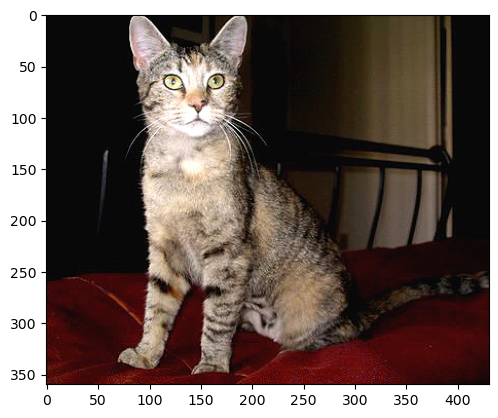

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(sample[0].permute([1,2,0]))

Unser Sample ist also eine Katze! Jetzt wissen wir auch, dass das `ImageFolder` Dataset Katzen mit dem Label `0`, und Hunde mit dem Label `1` versieht.  

<span style="color:white; background-color: red; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Aufgabe: </span> Ändere die `sample_id` und führe die oberen Notebook-Cells erneut aus (Zur Erinnerung: `Cmd/Ctrl+Enter` oder `Shift+Enter`), um dir noch ein paar weitere Samples ausgeben zu lassen. Was unterscheidet sich von Sample zu Sample? Wie könnte dieser Unterschied für unser Modell später zum Problem werden? 

<span style="color:white; background-color: #FFD700; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Bonus-Aufgabe: </span> Anstatt die `ImageFolder`-Klasse zu verwenden, implementiere deine eigene `Dataset` Subklasse um die Bilder und Labels zu laden. Nimm dir hierzu Inspiration am folgenden Guide: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files und nutze Python's `os`-Library, zum Beispiel die Funktion `os.walk()` (https://docs.python.org/3/library/os.html#os.walk).

### Pre-Processing

Wie du bereits bemerkt hast, haben unsere Bilder unterschiedliche Größen. Da wir aber mehrere Bilder zu einem "Batch" zusammenfassen und als gemeinsamer Tensor durch unser Model schicken werden, müssen wir ihre Größe zuerst auf einen gemeinsamen Nenner bringen. Dazu haben wir mehrere Möglichkeiten, die üblichsten sind jedoch die folgenden:
- Skalierung: Hier "dehnen" oder "stauchen" wir das Bild in die gewünschte Größe. Das Resultat sieht für Menschen oft verzerrt aus.
- Padding: Hier erhalten wir das Seitenverhältnis des Original-Bildes, und füllen die Ränder mit schwarzen Pixeln auf, um das Ziel-Seitenverhältnis zu erhalten.

Wir werden die erste Methode wählen, um unsere Bilder auf die einheitliche Größe $224 \times 224$ zu skalieren. Dazu verwenden wir den `Resize`-Transform aus der `torchvision`-Library. Da CNN-Modelle Inputs in der Range $[-1,1]$ erwarten, müssen wir außerdem noch die Werte in unseren Bild-Tensors von $[0,1]$ in diese Range konvertieren. Hierzu können wir den `Normalize`-Transform nutzen. Da unser `ImageFolder` nur einen `transform`-Parameter hat, kombinieren wir die Transformationen mittels `Compose` um sie der Reihe nach auszuführen: 

In [ ]:
from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

catsvsdogs_dataset = datasets.ImageFolder("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages", transform=transform)

Der "Cats-vs-Dogs" Datensatz legt uns noch ein paar weitere Stöcke vor die Füße: Die `Cats` und `Dogs` Ordner enthalten jeweils ein `Thumbs.db`-File, welches wir natürlich nicht als Bilder in unseren Datensatz aufnehmen wollen. Außerdem sind manche Bilder im Datensatz fehlerhaft und 0kb groß, diese wollen wir entsprechend auch filtern. Um beides zu erreichen, können wir unserem `ImageFolder` eine Funktion als `is_valid_file` Parameter übergeben, die beim Initialisieren des Datensatzes für jedes File im Ordner aufgerufen wird, um festzustellen, ob das File in den Datensatz aufgenommen werden soll. Wir erstellen also eine `validate_image` Funktion, die genau unsere zwei erwähnte Probleme überprüft.

<span style="color:white; background-color: red; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Aufgabe: </span> Prinzipiell könnten wir in der `validate_image` Funktion einfach versuchen, das Bild unter dem übergebenen Pfad zu laden, und `False` zurückgeben, wenn dabei ein Fehler auftritt. Warum sollten wir diesen Ansatz - wenn möglich - vermeiden?

In [ ]:
import os

def validate_image(src):
    return os.path.getsize(src) > 0 and src.endswith(".jpg")

catsvsdogs_dataset = datasets.ImageFolder("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages", transform=transform, is_valid_file=validate_image)

Fast geschafft! Als letzten Schritt müssen wir unsere Daten jetzt noch auf 3 Sets aufteilen: 
- Training-Set: enthält die Daten, mit dem wir unser Modell trainieren
- Validation-Set: enthält die Daten, mit dem wir die Performance unseres Modells beim Training einschätzen und Optimierungen machen
- Test-Set: heben wir bis ganz zum Schluss auf, um die finale Performance unseres Modells einschätzen zu können

Für die Größenverhältnisse der Sets gibt es keine harte Regel, eine häufige Aufteilung ist 60%/20%/20%. Mit der `random_split`-Funktion können wir unser `Dataset` in drei `Dataset`s aufteilen.

<span style="color:white; background-color: blue; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Info: </span> Abgesehen von der einmaligen Spaltung des Datensatzes in die oben genannten Sets gibt eine Reihe an aufwendigeren Techniken, um einen Datensatz für Training & Validierung aufzuteilen. Diese fallen meistens unter den Namen "Cross-Validation", und werden im folgenden Artikel gut erklärt: https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right. 

In [ ]:
import torch
from torch.utils.data import random_split


generator = torch.Generator().manual_seed(42)
catsvsdogs_train, catsvsdogs_val, catsvsdogs_test = random_split(catsvsdogs_dataset, [0.6, 0.2, 0.2], generator=generator)

## Unser Erstes Model

Nachdem wir unsere Daten vorbereitet haben, ist es nun endlich Zeit, unser Model zu bauen! Wir bauen ein Convolutional Neural Network (CNN), eine Architektur, die sich als sehr performant für die Arbeit mit Bildern herausgestellt hat. Wie viele Neural Network Architekturen ist ein CNN in Layern aufgebaut, bei denen der Output des vorangehenden Layers den Input des nächsten Layers darstellt. Dementsprechend sind die Inputs und Outputs aller Layer Tensors: Der Input des ersten Layers ist der $B \times 3 \times 224 \times 224$ Tensor unseres Bildes, der Output des letzten Layers ist ein $B \times 2$ Tensor. $B$ ist hierbei die "Batch-Size", also die Anzahl an Samples, die wir gleichzeitig durch das Model schicken, bevor wir mit Backpropagation die Weights des Models anpassen. Pro Input-Bild im Batch enthält der finale Output 2 Zahlen, die zusammen immer $1$ ergeben. Diese Zahlen können als die Wahrscheinlichkeiten gesehen werden, mit denen unser Model die Tatasche einstuft, dass es sich bei dem Bild um eine Katze (Label `0`, also die erste Zahl) oder einen Hund (Label `1`, also die zweite Zahl) handelt (wenn z.B. das Model für ein Bild die Zahlen `[0.95, 0.05]` zurückgibt, ist es ziemlich sicher, dass das Bild eine Katze zeigt). 

Wie kommen wir nun von einem $B \times 3 \times 224 \times 224$ Tensor zu einem $B \times 2$ Tensor? Das folgende Bild gibt einen schematischen Überblick:

<img style="width: 800px; height: auto;" src=" 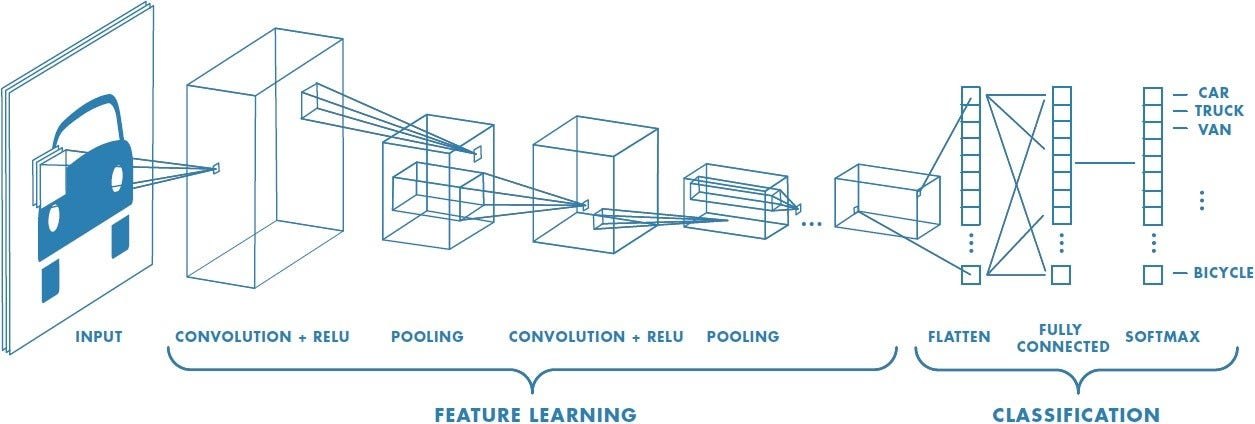">

Keine Sorge, im folgenden besprechen wir die einzelnen Layer-Typen des Models im Detail.

<span style="color:white; background-color: blue; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Info: </span> Der optimale Wert für die Batch-Size beim Training von einem Model ist von einer Reihe an Faktoren abhängig, unter anderem auch von der Menge an GPU Speicher, der mit den Bilddaten des Batches befüllt werden kann. Je nach Wahl des Optimizers, den wir zum Anpassen der Model-Weights verwenden, kann es auch nötig sein, die Learning Rate anzupassen, wenn die Batch Size geändert wird: https://www.baeldung.com/cs/learning-rate-batch-size. Wir werden den Adam-Optimizer verwenden, bei dem dies nicht nötig ist. 

### Die Layer eines CNN

#### Convolutional Layer
Wie der Name bereits vermuten lässt, sind Convolutional Layer der Kern eines CNNs. Ein Convolutional Layer besteht aus einem oder mehreren "Filtern". Jeder Filter ist ein $C \times K \times K$ Tensor an Weights (also `float`-Zahlen, die während des Trainings des Modells angepasst werden), wobei $C$ die Anzahl an Channels des Input-Layers (also z.B. $3$ für den ersten Convolutional Layer, der den $3 \times 224 \times 224$ Tensor unseres Input-Bildes als Input hat), und $K$ die sogenannte "Kernel-Size", also einfach die Größe des Filters, ist. Jeder Filter wird schrittweise über den Input-Tensor bewegt, und in jedem Schritt werden die Werte des Input-Tensors mit denen des Filters multipliziert und aufsummiert, um einen Wert im Output Tensor zu bestimmen: 

Jeder Filter erzeugt somit einen Channel im Output. Wir können uns also vorstellen, dass jeder Filter lernt, ein bestimmtes Muster in $K \times K$ Regionen seines Inputs zu erkennen, und ein Channel im Output eines Convolutional Layers den Grad angibt, zu dem dieses Muster in den unterschiedlichen Regionen des Inputs erkannt wurde. Wenn wir Convolutional Layer übereinander stapeln, die Outputs der Filter des ersten Layers also zum Input der Filter des nächsten werden, werden die erkannten Muster der höheren Layer immer und immer komplexer. Die Filter des ersten Convolution Layers könnten also z.B. lernen, simple Farbverläufe oder Kanten zu erkennen, während die Filter höherer Layer Dinge wie Augen oder Felltextur erkennen.  

In PyTorch kann ein Convolutional Layer mit der `Conv2d`-Klasse erstellt werden: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html. Wir verwenden ein `padding` von `"same"`, womit dem Input so zusätzliche $0$-Reihen und -Spalten hinzugefügt werden, dass die $H$ und $W$ Dimensionen des Inputs und Outputs gleich bleiben:



#### ReLU Activation Function
Zu diesem Zeitpunkt stellen die Outputs unserer CNN-Layer eine lineare Kombination ihrer Input-Werte dar. Wer sich schon einmal mit linearer Regression beschäftigt hat wird wissen, dass die Art von Beziehungen zwischen Input und Output, die nur mit linearer Kombination darstellbar ist, sehr eingeschränkt ist. Wir müssen also eine Art von Non-Linearität in unser Modell bringen, wofür wir eine sogenannte Activation Function nutzen: diese wird einfach einzeln auf jedes Element des Output-Tensors des vorherigen Layers angewandt. Wir verwenden die ReLU Activation Function, die wie folgt aussieht: 


In PyTorch kann ein ReLU Layer mit der `ReLU`-Klasse erstellt werden: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html. Wir ordnen diese immer nach einem Convolutional Layer an.

<span style="color:white; background-color: blue; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Info: </span> Die ReLU Funktion wird eingesetzt, um das [Vanishing Gradient Problem](https://www.kdnuggets.com/2022/02/vanishing-gradient-problem.html) zu bekämpfen, das beim Trainieren von vielschichtigen Modellen mit den zuvor populären Sigmoid und TanH Activation Functions auftritt. Sie ist jedoch bei weitem nicht die einzige Option. Eine Übersicht über andere Activation Functions findest du hier: https://en.wikipedia.org/wiki/Activation_function. 

#### Max Pooling Layer 
Um die $H$ und $W$ Dimensionen des Inputs zu verringern, verwenden wir Pooling Layer. Diese fassen einfach pro Channel eine Gruppe an nebeneinander liegenden Inputs zusammen. Die populärsten Arten von Pooling sind Max und Average Pooling. Verwenden wir beispielsweise Max Pooling mit einer Kernel Size von $2$, und der Input unseres Max Pooling Layers hat die Dimensionen $C \times H \times W$, wird der Output die Dimensionen $C \times H/2 \times W/2$ haben, wobei jeder Eintrag das Maximum eines $2\times2$ Rechtecks im Input darstellt. 

Warum würden wir das tun wollen? Erstens, um die Größe unseres Input-Tensors über das Modell hinweg schrittweise zu verkleinern. Zweitens, um das Modell weniger anfällig für die genaue Position eines erkannten Musters zu machen, indem wir nebeneinander liegende Muster-Erkennungen zusammenfassen.

In PyTorch kann ein Max Pooling Layer mit der `MaxPool2d`-Klasse erstellt werden: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html. Gewöhnlich ordnen wir Pooling Layer nach der Activation Function eines Convolutional Layers an. 

#### Flattening Layer
Nach einem Stapel an Convolutional-Activation-Pooling Layern, die alle die 3-dimensionale $C \times H \times W$ Struktur unseres Bild-Inputs beibehalten, brauchen wir einen Layer, der diese in die 1-dimensionale Struktur unseres finalen Outputs umwandelt. Ein Flattening Layer tut genau das: Er hat als Input einen $B \times C \times H \times W$ Tensor, und gibt als Output einen $B \times (C \cdot H \cdot W)$ Tensor zurück. 

In PyTorch wird dieser Layer mit der `Flatten`-Klasse erstellt: https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html. 

#### Fully Connected Layer
Um den $B \times (C \cdot H \cdot W)$ Output unseres Flattening Layers auf unseren finalen $B \times 2$ Output zu reduzieren, bauen wir ein paar Fully Connected Layer ein. Diese sind die ganz klassischen Neural Network Layer: Jeder Layer besteht aus $N$ Neuronen, die mit allen $M$ Neuronen des vorhergehenden Layers verbunden sind. Pro Sample im Batch wird in jedem Neuron der Output der $M$ Vorgänger mit einem anderen Weight multipliziert, und zusammenaddiert (inkl. einem Bias-Weight), um den Output des Neurons zu bestimmen. Aus einem $B \times M$ Input wird somit ein $B \times N$ Output. 

In PyTorch wird dieser Layer mit der `Linear`-Klasse erstellt: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html. Wie bei den Convolutional Layers ordnen wir hinter jedem Fully Connected Layer eine ReLU Activation Function an.

#### Softmax Layer
Mit einem oder mehreren Fully Connected Layern können wir unseren Output auf $B \times 2$ Dimensionen reduzieren. Pro Sample im Batch können die 2 resultierenden Zahlen jedoch jeden beliebigen Wert von $- \infty$ bis $+\infty$ haben. Um diese in Wahrscheinlichkeiten umzuwandeln, die auf $1$ aufsummieren, verwenden wir die [Softmax Activation Function](https://en.wikipedia.org/wiki/Softmax_function). 

In PyTorch können wir einen Softmax-Layer mit der `Softmax`-Klasse erstellen: https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html. Unser Input für den Softmax-Layer wird das Format $B \times 2$ haben, und wir wollen, dass die Werte pro Sample auf $1$ summieren, somit geben wir als `dim` den Wert `1` an (die Dimensions-Indizes starten bei 0). 




### Das Model 
Nach dieser Flut an Erklärungen können wir endlich unser Model bauen, uns fehlt aber noch die genaue Konfiguration und die Anordnung der einzelnen Layer. Hier orientieren wir uns am VGG16 Model, welches 2014 für ImageNet vorgeschlagen wurde (ein Datensatz an >14 Millionen Bildern, die in 1.000 verschiedene Klassen eingeteilt sind), und damals State-of-the-Art Performance lieferte. Das Model wird im folgenden Paper näher erläutert: https://arxiv.org/abs/1409.1556, wir richten uns aber an dieser übersichtlicheren Grafik: 


Um die Anzahl an Weights des Modells klein zu halten und das Training zu beschleunigen, treffen wir ein paar Anpassungen:
- Statt mehreren ident konfigurierten Convolutional Layern zwischen den Pooling Layern verwenden wir immer nur einen
- Statt $4096$ verpassen wir den ersten zwei Fully-Connected Layern nur $512$ und $128$ Neurons
- Da wir nur zwischen 2 Klassen unterscheiden wollen, hat der dritte Fully-Connected Layer nur $2$ und nicht $1000$ Neurons

<span style="color:white; background-color: red; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Aufgabe: </span> Nutze die `Sequential` Funktion von PyTorch (https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html), um das VGG 16 Model mit den erwähnten Modifikationen in der nächsten Notebook-Cell nachzubauen. Du benötigst ausschließlich die Layer-Typen, die vorher besprochen wurden. Falls du anstehst, klappe die Referenzlösung in der übernächsten Notebook-Cell aus. 

<span style="color:white; background-color: #FFD700; padding: 3px 6px; border-radius: 2px; margin-right: 5px;">Bonus-Aufgabe: </span> Um kompliziertere Model-Strukturen abzubilden, können PyTorch Models auch als Subklasse der `Module`-Klasse gebaut werden. Orientiere dich an folgendem Guide, um das VGG 16 Model auf diese Art zu konstruieren: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network. Du kannst ebenfalls die [funktionalen Varianten](https://pytorch.org/docs/stable/nn.functional.html) jener Layer verwenden, die keine trainierbaren Weights enthalten (also alle außer der Convolutional und Fully-Connected Layer).

In [ ]:
import torch.nn as nn

catsvsdogs_model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3,3), padding="same"),
    nn.ReLU(),
    # Ergänze die restlichen Layer
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Referenz-Lösung
catsvsdogs_model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3,3), padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, kernel_size=(3,3), padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, kernel_size=(3,3), padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, kernel_size=(3,3), padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 512, kernel_size=(3,3), padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(512 * 7 * 7, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
)

Da wir das Model auf der GPU laufen lassen wollen, müssen wir es zuerst dorthin kopieren. Das geht mit PyTorch sehr einfach, nämlich mit der Methode `.to()`. Haben wir nur eine Nvidia-Grafikkarte im System, ist diese unter dem Namen `"cuda"` verfügbar.

In [ ]:
catsvsdogs_model = catsvsdogs_model.to("cuda")

Ob wir unsere Layer richtig konfiguriert haben, sehen wir mit der `summary()` Funktion der `torchinfo`-Library. Diese gibt uns eine Übersicht über die Layer unseres Modells und die Anzahl an Weights (Params) pro Layer:

In [12]:
from torchinfo import summary
import torch

print(summary(catsvsdogs_model, input_size=(16, 3, 224, 224), device="cuda"))

Layer (type:depth-idx)                   Output Shape              Param #
CatsVsDogsNetwork                        [16, 2]                   --
├─Conv2d: 1-1                            [16, 64, 224, 224]        1,792
├─MaxPool2d: 1-2                         [16, 64, 112, 112]        --
├─Conv2d: 1-3                            [16, 128, 112, 112]       73,856
├─MaxPool2d: 1-4                         [16, 128, 56, 56]         --
├─Conv2d: 1-5                            [16, 256, 56, 56]         295,168
├─MaxPool2d: 1-6                         [16, 256, 28, 28]         --
├─Conv2d: 1-7                            [16, 512, 28, 28]         1,180,160
├─MaxPool2d: 1-8                         [16, 512, 14, 14]         --
├─Conv2d: 1-9                            [16, 512, 14, 14]         2,359,808
├─MaxPool2d: 1-10                        [16, 512, 7, 7]           --
├─Linear: 1-11                           [16, 1024]                25,691,136
├─Linear: 1-12                           [16, 256] 

## Training

In [18]:
training_loader = torch.utils.data.DataLoader(catsvsdogs_train, batch_size=64, shuffle=True, num_workers=2, prefetch_factor=5)
validation_loader = torch.utils.data.DataLoader(catsvsdogs_val, batch_size=64, shuffle=True, num_workers=2, prefetch_factor=5)

In [19]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(catsvsdogs_model.parameters(), lr=0.00005)

In [20]:
from sklearn.metrics import accuracy_score

def train_one_epoch(model, training_loader, optimizer, loss_fn, epoch_index):
    running_loss = 0.
    running_accuracy = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to("cuda"), data[1].to("cuda")

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        running_accuracy += accuracy_score(data[1], outputs.argmax(dim=-1).cpu())
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            last_accuracy = running_accuracy / 10 # loss per batch
            print('  batch {} loss: {:.6f} accuracy: {:.4f}%'.format(i + 1, last_loss, last_accuracy))
            running_loss = 0.
            running_accuracy = 0.
            
        del inputs, labels, loss

    return last_loss

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
from datetime import datetime


def train(model, training_loader, validation_loader, optimizer, loss_fn, epochs=5, model_name="model"):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    epoch_number = 0
    best_vloss = 1_000_000.
    
    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model, training_loader, optimizer, loss_fn, epoch_number)


        running_vloss = 0.0
        running_vaccuracy = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata[0].to("cuda"), vdata[1].to("cuda")
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                vaccuracy = accuracy_score(vdata[1], voutputs.argmax(dim=-1).cpu())
                running_vloss += vloss
                running_vaccuracy += vaccuracy

        avg_vloss = running_vloss / (i + 1)
        avg_vaccuracy = running_vaccuracy / (i + 1)
        print('LOSS train {:.6f} valid {:.6f} ACCURACY valid {:.4f}%'.format(avg_loss, avg_vloss, avg_vaccuracy))

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = '{}_{}_{}'.format(model_name, timestamp, epoch_number)
            torch.save(model.state_dict(), model_path)

        epoch_number += 1

In [ ]:
train(catsvsdogs_model, training_loader, validation_loader, optimizer, loss_fn, epochs=10)

EPOCH 1:
  batch 10 loss: 0.704132 accuracy: 0.4906%
  batch 20 loss: 0.692769 accuracy: 0.5172%
  batch 30 loss: 0.692756 accuracy: 0.5062%
  batch 40 loss: 0.686336 accuracy: 0.5484%
  batch 50 loss: 0.682476 accuracy: 0.5375%
  batch 60 loss: 0.661935 accuracy: 0.6156%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 70 loss: 0.686966 accuracy: 0.5828%
  batch 80 loss: 0.667534 accuracy: 0.6047%
  batch 90 loss: 0.666384 accuracy: 0.5891%
  batch 100 loss: 0.658914 accuracy: 0.5969%
  batch 110 loss: 0.650402 accuracy: 0.6141%
  batch 120 loss: 0.679916 accuracy: 0.5578%
  batch 130 loss: 0.653749 accuracy: 0.6219%
  batch 140 loss: 0.639833 accuracy: 0.6344%
  batch 150 loss: 0.607900 accuracy: 0.6922%
  batch 160 loss: 0.611465 accuracy: 0.6844%
  batch 170 loss: 0.625168 accuracy: 0.6719%
  batch 180 loss: 0.594454 accuracy: 0.6953%
  batch 190 loss: 0.601254 accuracy: 0.6844%
  batch 200 loss: 0.609560 accuracy: 0.6734%
  batch 210 loss: 0.595909 accuracy: 0.6813%
  batch 220 loss: 0.581680 accuracy: 0.7203%
  batch 230 loss: 0.559754 accuracy: 0.7344%
LOSS train 0.559754 valid 0.574501 ACCURACY valid 0.7172%
EPOCH 2:
  batch 10 loss: 0.568970 accuracy: 0.7203%
  batch 20 loss: 0.559912 accuracy: 0.7234%
  batch 30 loss: 0.574695 accuracy: 0.7094%
  batch 40 loss: 0.557644 accuracy: 0.7

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 150 loss: 0.553527 accuracy: 0.7359%
  batch 160 loss: 0.543987 accuracy: 0.7547%
  batch 170 loss: 0.550404 accuracy: 0.7500%
  batch 180 loss: 0.536870 accuracy: 0.7609%
  batch 190 loss: 0.562563 accuracy: 0.7312%
  batch 200 loss: 0.547123 accuracy: 0.7375%
  batch 210 loss: 0.537694 accuracy: 0.7562%
  batch 220 loss: 0.530067 accuracy: 0.7594%
  batch 230 loss: 0.544174 accuracy: 0.7406%
LOSS train 0.544174 valid 0.522252 ACCURACY valid 0.7801%
EPOCH 3:
  batch 10 loss: 0.519011 accuracy: 0.7828%
  batch 20 loss: 0.499315 accuracy: 0.7969%
  batch 30 loss: 0.539612 accuracy: 0.7656%
  batch 40 loss: 0.521925 accuracy: 0.7797%
  batch 50 loss: 0.512138 accuracy: 0.7984%
  batch 60 loss: 0.531348 accuracy: 0.7609%
  batch 70 loss: 0.511735 accuracy: 0.7937%
  batch 80 loss: 0.489755 accuracy: 0.8141%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 90 loss: 0.528196 accuracy: 0.7703%
  batch 100 loss: 0.532165 accuracy: 0.7688%
  batch 110 loss: 0.532751 accuracy: 0.7641%
  batch 120 loss: 0.517581 accuracy: 0.7750%
  batch 130 loss: 0.527540 accuracy: 0.7734%
  batch 140 loss: 0.524965 accuracy: 0.7703%
  batch 150 loss: 0.481470 accuracy: 0.8266%
  batch 160 loss: 0.495825 accuracy: 0.8078%
  batch 170 loss: 0.505434 accuracy: 0.7859%
  batch 180 loss: 0.508434 accuracy: 0.7984%
  batch 190 loss: 0.490703 accuracy: 0.8219%
  batch 200 loss: 0.482670 accuracy: 0.8250%
  batch 210 loss: 0.493665 accuracy: 0.8078%
  batch 220 loss: 0.475025 accuracy: 0.8313%
  batch 230 loss: 0.487151 accuracy: 0.8234%
LOSS train 0.487151 valid 0.490649 ACCURACY valid 0.8099%
EPOCH 4:
  batch 10 loss: 0.467094 accuracy: 0.8359%
  batch 20 loss: 0.475830 accuracy: 0.8313%
  batch 30 loss: 0.464530 accuracy: 0.8391%
  batch 40 loss: 0.478921 accuracy: 0.8297%
  batch 50 loss: 0.495536 accuracy: 0.8172%
  batch 60 loss: 0.474524 accuracy: 0.8

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 230 loss: 0.489012 accuracy: 0.8219%
LOSS train 0.489012 valid 0.475982 ACCURACY valid 0.8236%
EPOCH 5:
  batch 10 loss: 0.438153 accuracy: 0.8797%
  batch 20 loss: 0.448504 accuracy: 0.8609%
  batch 30 loss: 0.431616 accuracy: 0.8812%
  batch 40 loss: 0.455801 accuracy: 0.8516%
  batch 50 loss: 0.486298 accuracy: 0.8141%
  batch 60 loss: 0.485621 accuracy: 0.8094%
  batch 70 loss: 0.462185 accuracy: 0.8406%
  batch 80 loss: 0.451970 accuracy: 0.8547%
  batch 90 loss: 0.442737 accuracy: 0.8609%
  batch 100 loss: 0.455615 accuracy: 0.8484%
  batch 110 loss: 0.431367 accuracy: 0.8688%
  batch 120 loss: 0.452987 accuracy: 0.8578%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 130 loss: 0.441891 accuracy: 0.8641%
  batch 140 loss: 0.428276 accuracy: 0.8906%
  batch 150 loss: 0.465846 accuracy: 0.8328%
  batch 160 loss: 0.461212 accuracy: 0.8484%
  batch 170 loss: 0.485468 accuracy: 0.8219%
  batch 180 loss: 0.476567 accuracy: 0.8266%
  batch 190 loss: 0.430972 accuracy: 0.8672%
  batch 200 loss: 0.451065 accuracy: 0.8531%
  batch 210 loss: 0.439952 accuracy: 0.8703%
  batch 220 loss: 0.442684 accuracy: 0.8625%
  batch 230 loss: 0.475613 accuracy: 0.8266%
LOSS train 0.475613 valid 0.468083 ACCURACY valid 0.8366%
EPOCH 6:
  batch 10 loss: 0.436195 accuracy: 0.8766%
  batch 20 loss: 0.448514 accuracy: 0.8641%
  batch 30 loss: 0.457988 accuracy: 0.8484%
  batch 40 loss: 0.439274 accuracy: 0.8688%
  batch 50 loss: 0.422445 accuracy: 0.8891%
  batch 60 loss: 0.434562 accuracy: 0.8766%
  batch 70 loss: 0.438950 accuracy: 0.8703%
  batch 80 loss: 0.449682 accuracy: 0.8547%
  batch 90 loss: 0.436162 accuracy: 0.8719%
  batch 100 loss: 0.430453 accuracy: 0.878

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 180 loss: 0.425101 accuracy: 0.8859%
  batch 190 loss: 0.437591 accuracy: 0.8656%
  batch 200 loss: 0.426506 accuracy: 0.8797%
  batch 210 loss: 0.430751 accuracy: 0.8734%
  batch 220 loss: 0.439085 accuracy: 0.8703%
  batch 230 loss: 0.402766 accuracy: 0.9094%
LOSS train 0.402766 valid 0.444622 ACCURACY valid 0.8608%
EPOCH 7:
  batch 10 loss: 0.420571 accuracy: 0.8875%
  batch 20 loss: 0.436946 accuracy: 0.8641%
  batch 30 loss: 0.401580 accuracy: 0.9031%
  batch 40 loss: 0.394191 accuracy: 0.9156%
  batch 50 loss: 0.404436 accuracy: 0.9047%
  batch 60 loss: 0.410982 accuracy: 0.8984%
  batch 70 loss: 0.411274 accuracy: 0.8984%
  batch 80 loss: 0.419462 accuracy: 0.8922%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 90 loss: 0.424843 accuracy: 0.8859%
  batch 100 loss: 0.416001 accuracy: 0.8906%
  batch 110 loss: 0.413830 accuracy: 0.8984%
  batch 120 loss: 0.406375 accuracy: 0.9078%
  batch 130 loss: 0.433358 accuracy: 0.8719%
  batch 140 loss: 0.407673 accuracy: 0.8984%
  batch 150 loss: 0.405624 accuracy: 0.9047%
  batch 160 loss: 0.422553 accuracy: 0.8859%
  batch 170 loss: 0.405837 accuracy: 0.9062%
  batch 180 loss: 0.444812 accuracy: 0.8609%
  batch 190 loss: 0.410740 accuracy: 0.8953%
  batch 200 loss: 0.415906 accuracy: 0.8906%
  batch 210 loss: 0.400444 accuracy: 0.9078%
  batch 220 loss: 0.430156 accuracy: 0.8781%
  batch 230 loss: 0.411016 accuracy: 0.8969%
LOSS train 0.411016 valid 0.438034 ACCURACY valid 0.8703%
EPOCH 8:
  batch 10 loss: 0.375665 accuracy: 0.9313%
  batch 20 loss: 0.414196 accuracy: 0.8938%
  batch 30 loss: 0.390302 accuracy: 0.9250%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 40 loss: 0.413261 accuracy: 0.8938%


## Data Augmentation

In [22]:
from torch.utils.data import Dataset

class LazyTransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)
    
transform_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((224,224), (0.7,1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

catsvsdogs_dataset = datasets.ImageFolder("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages", is_valid_file=validate_image)

generator = torch.Generator().manual_seed(42)
catsvsdogs_train_raw, catsvsdogs_val_raw, catsvsdogs_test_raw = random_split(catsvsdogs_dataset, [0.6, 0.2, 0.2], generator=generator)
catsvsdogs_train_aug = LazyTransformDataset(catsvsdogs_train_raw, transform=transform_train)
catsvsdogs_val_aug = LazyTransformDataset(catsvsdogs_val_raw, transform=transform_val)

In [33]:
training_loader_aug = torch.utils.data.DataLoader(catsvsdogs_train_aug, batch_size=64, shuffle=True, num_workers=2, prefetch_factor=5)
validation_loader_aug = torch.utils.data.DataLoader(catsvsdogs_val_aug, batch_size=64, shuffle=True, num_workers=2, prefetch_factor=5)

In [27]:
catsvsdogs_model_aug = CatsVsDogsNetwork().to("cuda")
optimizer_aug = torch.optim.Adam(catsvsdogs_model_aug.parameters(), lr=0.00005)

In [28]:
train(catsvsdogs_model_aug, training_loader_aug, validation_loader_aug, optimizer_aug, loss_fn, epochs=10)

EPOCH 1:
  batch 10 loss: 0.694976 accuracy: 0.5125%
  batch 20 loss: 0.693702 accuracy: 0.4766%
  batch 30 loss: 0.693284 accuracy: 0.4953%
  batch 40 loss: 0.692263 accuracy: 0.5211%
  batch 50 loss: 0.685715 accuracy: 0.5570%
  batch 60 loss: 0.668257 accuracy: 0.6164%
  batch 70 loss: 0.657268 accuracy: 0.6180%
  batch 80 loss: 0.652963 accuracy: 0.6180%
  batch 90 loss: 0.638198 accuracy: 0.6344%
  batch 100 loss: 0.638994 accuracy: 0.6398%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 110 loss: 0.623560 accuracy: 0.6609%
LOSS train 0.623560 valid 0.632965 ACCURACY valid 0.6498%
EPOCH 2:
  batch 10 loss: 0.627918 accuracy: 0.6398%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 20 loss: 0.627478 accuracy: 0.6570%
  batch 30 loss: 0.597986 accuracy: 0.6961%
  batch 40 loss: 0.595392 accuracy: 0.6906%
  batch 50 loss: 0.607057 accuracy: 0.6852%
  batch 60 loss: 0.582452 accuracy: 0.7063%
  batch 70 loss: 0.574348 accuracy: 0.7141%
  batch 80 loss: 0.602475 accuracy: 0.6852%
  batch 90 loss: 0.578029 accuracy: 0.7148%


KeyboardInterrupt: 

## Batch Normalization

In [50]:
import torch.nn as nn
import torch.nn.functional as F


catsvsdogs_model_norm = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3,3), padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, kernel_size=(3,3), padding="same"),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, kernel_size=(3,3), padding="same"),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 512, kernel_size=(3,3), padding="same"),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(512, 512, kernel_size=(3,3), padding="same"),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(512 * 7 * 7, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
).to("cuda")

In [51]:
optimizer_norm = torch.optim.Adam(catsvsdogs_model_norm.parameters(), lr=0.00005)

In [52]:
train(catsvsdogs_model_norm, training_loader_aug, validation_loader_aug, optimizer_norm, loss_fn, epochs=10)

EPOCH 1:
  batch 10 loss: 0.684903 accuracy: 0.5547%
  batch 20 loss: 0.622882 accuracy: 0.6766%
  batch 30 loss: 0.636232 accuracy: 0.6453%
  batch 40 loss: 0.624447 accuracy: 0.6438%
  batch 50 loss: 0.613288 accuracy: 0.6625%
  batch 60 loss: 0.592814 accuracy: 0.7078%
  batch 70 loss: 0.587543 accuracy: 0.6984%
  batch 80 loss: 0.596909 accuracy: 0.7047%
  batch 90 loss: 0.580525 accuracy: 0.7047%
  batch 100 loss: 0.558443 accuracy: 0.7422%
  batch 110 loss: 0.578335 accuracy: 0.7125%
  batch 120 loss: 0.546510 accuracy: 0.7500%
  batch 130 loss: 0.549436 accuracy: 0.7469%
  batch 140 loss: 0.562235 accuracy: 0.7266%
  batch 150 loss: 0.543208 accuracy: 0.7562%
  batch 160 loss: 0.580813 accuracy: 0.7016%
  batch 170 loss: 0.542304 accuracy: 0.7609%
  batch 180 loss: 0.543152 accuracy: 0.7547%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 190 loss: 0.547035 accuracy: 0.7578%
  batch 200 loss: 0.542453 accuracy: 0.7516%
  batch 210 loss: 0.534707 accuracy: 0.7594%
  batch 220 loss: 0.532308 accuracy: 0.7703%
  batch 230 loss: 0.551066 accuracy: 0.7328%
LOSS train 0.551066 valid 0.524183 ACCURACY valid 0.7773%
EPOCH 2:
  batch 10 loss: 0.523038 accuracy: 0.7781%
  batch 20 loss: 0.529952 accuracy: 0.7609%
  batch 30 loss: 0.536772 accuracy: 0.7547%
  batch 40 loss: 0.538664 accuracy: 0.7594%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 50 loss: 0.553718 accuracy: 0.7359%
  batch 60 loss: 0.517056 accuracy: 0.7906%
  batch 70 loss: 0.542612 accuracy: 0.7578%
  batch 80 loss: 0.518215 accuracy: 0.7719%
  batch 90 loss: 0.522252 accuracy: 0.7781%
  batch 100 loss: 0.550137 accuracy: 0.7344%
  batch 110 loss: 0.513996 accuracy: 0.7797%
  batch 120 loss: 0.514321 accuracy: 0.7844%
  batch 130 loss: 0.496240 accuracy: 0.8125%
  batch 140 loss: 0.492038 accuracy: 0.8094%
  batch 150 loss: 0.474519 accuracy: 0.8297%
  batch 160 loss: 0.499465 accuracy: 0.8031%
  batch 170 loss: 0.471071 accuracy: 0.8313%
  batch 180 loss: 0.486180 accuracy: 0.8187%
  batch 190 loss: 0.487546 accuracy: 0.8203%
  batch 200 loss: 0.507438 accuracy: 0.7906%
  batch 210 loss: 0.499695 accuracy: 0.8047%
  batch 220 loss: 0.519385 accuracy: 0.7797%
  batch 230 loss: 0.477878 accuracy: 0.8297%
LOSS train 0.477878 valid 0.493428 ACCURACY valid 0.8093%
EPOCH 3:
  batch 10 loss: 0.506306 accuracy: 0.7922%
  batch 20 loss: 0.472564 accuracy: 0.8

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 40 loss: 0.499868 accuracy: 0.7969%
  batch 50 loss: 0.486418 accuracy: 0.8203%
  batch 60 loss: 0.500741 accuracy: 0.7984%
  batch 70 loss: 0.478759 accuracy: 0.8313%
  batch 80 loss: 0.478631 accuracy: 0.8234%
  batch 90 loss: 0.474336 accuracy: 0.8391%
  batch 100 loss: 0.470548 accuracy: 0.8344%
  batch 110 loss: 0.489756 accuracy: 0.8094%
  batch 120 loss: 0.503196 accuracy: 0.7906%
  batch 130 loss: 0.485658 accuracy: 0.8109%
  batch 140 loss: 0.489502 accuracy: 0.8219%
  batch 150 loss: 0.473548 accuracy: 0.8234%
  batch 160 loss: 0.517772 accuracy: 0.7812%
  batch 170 loss: 0.496036 accuracy: 0.8000%
  batch 180 loss: 0.483194 accuracy: 0.8219%
  batch 190 loss: 0.485614 accuracy: 0.8234%
  batch 200 loss: 0.507760 accuracy: 0.7828%
  batch 210 loss: 0.478262 accuracy: 0.8313%
  batch 220 loss: 0.477928 accuracy: 0.8172%
  batch 230 loss: 0.493390 accuracy: 0.8141%
LOSS train 0.493390 valid 0.485743 ACCURACY valid 0.8192%
EPOCH 4:
  batch 10 loss: 0.473465 accuracy: 0.8

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 40 loss: 0.476355 accuracy: 0.8344%
  batch 50 loss: 0.490493 accuracy: 0.8141%
  batch 60 loss: 0.482802 accuracy: 0.8234%
  batch 70 loss: 0.465647 accuracy: 0.8359%
  batch 80 loss: 0.456697 accuracy: 0.8516%
  batch 90 loss: 0.474660 accuracy: 0.8297%
  batch 100 loss: 0.480510 accuracy: 0.8219%
  batch 110 loss: 0.471330 accuracy: 0.8313%
  batch 120 loss: 0.465551 accuracy: 0.8375%
  batch 130 loss: 0.468281 accuracy: 0.8422%
  batch 140 loss: 0.464766 accuracy: 0.8406%
  batch 150 loss: 0.476527 accuracy: 0.8406%
  batch 160 loss: 0.444102 accuracy: 0.8656%
  batch 170 loss: 0.466520 accuracy: 0.8406%
  batch 180 loss: 0.457507 accuracy: 0.8500%
  batch 190 loss: 0.436656 accuracy: 0.8734%
  batch 200 loss: 0.479248 accuracy: 0.8375%
  batch 210 loss: 0.476793 accuracy: 0.8234%
  batch 220 loss: 0.466043 accuracy: 0.8375%
  batch 230 loss: 0.453117 accuracy: 0.8578%
LOSS train 0.453117 valid 0.515212 ACCURACY valid 0.7860%
EPOCH 5:
  batch 10 loss: 0.465019 accuracy: 0.8

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 80 loss: 0.429399 accuracy: 0.8828%
  batch 90 loss: 0.450924 accuracy: 0.8578%
  batch 100 loss: 0.430031 accuracy: 0.8828%
  batch 110 loss: 0.441400 accuracy: 0.8672%
  batch 120 loss: 0.444866 accuracy: 0.8641%
  batch 130 loss: 0.451723 accuracy: 0.8453%
  batch 140 loss: 0.473430 accuracy: 0.8375%
  batch 150 loss: 0.439070 accuracy: 0.8656%
  batch 160 loss: 0.455584 accuracy: 0.8500%
  batch 170 loss: 0.430410 accuracy: 0.8844%
  batch 180 loss: 0.448163 accuracy: 0.8547%
  batch 190 loss: 0.437611 accuracy: 0.8703%
  batch 200 loss: 0.434675 accuracy: 0.8672%
  batch 210 loss: 0.431692 accuracy: 0.8781%
  batch 220 loss: 0.450509 accuracy: 0.8484%
  batch 230 loss: 0.464907 accuracy: 0.8469%
LOSS train 0.464907 valid 0.449689 ACCURACY valid 0.8554%
EPOCH 6:
  batch 10 loss: 0.440558 accuracy: 0.8625%
  batch 20 loss: 0.435475 accuracy: 0.8688%
  batch 30 loss: 0.449803 accuracy: 0.8578%
  batch 40 loss: 0.417491 accuracy: 0.8938%
  batch 50 loss: 0.445225 accuracy: 0.8

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 200 loss: 0.418602 accuracy: 0.8906%
  batch 210 loss: 0.405920 accuracy: 0.9016%
  batch 220 loss: 0.426173 accuracy: 0.8828%
  batch 230 loss: 0.442899 accuracy: 0.8594%
LOSS train 0.442899 valid 0.436303 ACCURACY valid 0.8673%
EPOCH 7:
  batch 10 loss: 0.440130 accuracy: 0.8609%
  batch 20 loss: 0.433932 accuracy: 0.8750%
  batch 30 loss: 0.446826 accuracy: 0.8562%
  batch 40 loss: 0.421373 accuracy: 0.8891%
  batch 50 loss: 0.443445 accuracy: 0.8641%
  batch 60 loss: 0.425635 accuracy: 0.8781%
  batch 70 loss: 0.436741 accuracy: 0.8797%


KeyboardInterrupt: 

## Transfer Learning

In [4]:
from torchvision.models import resnet50,ResNet50_Weights
import torch

resnet50_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

for param in resnet50_model.parameters():
    param.requires_grad = False
    
catsvsdogs_model_transfer = torch.nn.Sequential(
    resnet50_model,
    torch.nn.ReLU(),
    torch.nn.Linear(1000,200),
    torch.nn.ReLU(),
    torch.nn.Linear(200,2),
    torch.nn.Softmax(dim=1)
).to("cuda")

In [5]:
print(summary(catsvsdogs_model_transfer, input_size=(16, 3, 224, 224), device="cuda"))

NameError: name 'summary' is not defined

In [133]:
optimizer_transfer = torch.optim.Adam(catsvsdogs_model_transfer.parameters(), lr=0.00005)
train(catsvsdogs_model_transfer, optimizer_transfer, loss_fn, model_name="transfer")

EPOCH 1:
  batch 10 loss: 0.690695 accuracy: 0.5844%
  batch 20 loss: 0.669628 accuracy: 0.6016%
  batch 30 loss: 0.636192 accuracy: 0.6328%
  batch 40 loss: 0.632001 accuracy: 0.6469%
  batch 50 loss: 0.662967 accuracy: 0.6125%
  batch 60 loss: 0.644579 accuracy: 0.6375%
  batch 70 loss: 0.633384 accuracy: 0.6375%
  batch 80 loss: 0.602812 accuracy: 0.6844%
  batch 90 loss: 0.612367 accuracy: 0.6734%
  batch 100 loss: 0.598335 accuracy: 0.6969%
  batch 110 loss: 0.596885 accuracy: 0.6844%
  batch 120 loss: 0.598718 accuracy: 0.6828%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 130 loss: 0.597807 accuracy: 0.6984%
  batch 140 loss: 0.582072 accuracy: 0.7109%
  batch 150 loss: 0.577451 accuracy: 0.7234%
  batch 160 loss: 0.581840 accuracy: 0.7094%
  batch 170 loss: 0.585121 accuracy: 0.7141%
  batch 180 loss: 0.564732 accuracy: 0.7297%
  batch 190 loss: 0.577855 accuracy: 0.7266%
  batch 200 loss: 0.639566 accuracy: 0.6516%
  batch 210 loss: 0.578342 accuracy: 0.7188%
  batch 220 loss: 0.567794 accuracy: 0.7344%
  batch 230 loss: 0.547326 accuracy: 0.7578%
LOSS train 0.547326 valid 0.645771 ACCURACY valid 0.6468%
EPOCH 2:
  batch 10 loss: 0.552913 accuracy: 0.7500%
  batch 20 loss: 0.548974 accuracy: 0.7562%
  batch 30 loss: 0.533563 accuracy: 0.7641%
  batch 40 loss: 0.534767 accuracy: 0.7734%
  batch 50 loss: 0.548696 accuracy: 0.7500%
  batch 60 loss: 0.528924 accuracy: 0.7781%
  batch 70 loss: 0.527293 accuracy: 0.7781%
  batch 80 loss: 0.562967 accuracy: 0.7250%
  batch 90 loss: 0.542622 accuracy: 0.7656%
  batch 100 loss: 0.554997 accuracy: 0.739

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 180 loss: 0.534976 accuracy: 0.7625%
  batch 190 loss: 0.523040 accuracy: 0.7734%
  batch 200 loss: 0.516002 accuracy: 0.7844%
  batch 210 loss: 0.500263 accuracy: 0.7922%
  batch 220 loss: 0.498843 accuracy: 0.8063%
  batch 230 loss: 0.524254 accuracy: 0.7766%
LOSS train 0.524254 valid 0.511853 ACCURACY valid 0.7909%
EPOCH 3:
  batch 10 loss: 0.511830 accuracy: 0.7984%
  batch 20 loss: 0.492362 accuracy: 0.8156%
  batch 30 loss: 0.507667 accuracy: 0.7969%


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 40 loss: 0.522493 accuracy: 0.7828%
  batch 50 loss: 0.529895 accuracy: 0.7672%
  batch 60 loss: 0.524069 accuracy: 0.7750%
  batch 70 loss: 0.535981 accuracy: 0.7625%
  batch 80 loss: 0.515251 accuracy: 0.7953%
  batch 90 loss: 0.495608 accuracy: 0.8047%
  batch 100 loss: 0.492564 accuracy: 0.8109%
  batch 110 loss: 0.512090 accuracy: 0.7844%
  batch 120 loss: 0.519701 accuracy: 0.7828%
  batch 130 loss: 0.484358 accuracy: 0.8172%
  batch 140 loss: 0.494355 accuracy: 0.8094%
  batch 150 loss: 0.481798 accuracy: 0.8156%
  batch 160 loss: 0.504242 accuracy: 0.7937%
  batch 170 loss: 0.505156 accuracy: 0.8000%
  batch 180 loss: 0.485232 accuracy: 0.8156%
  batch 190 loss: 0.468759 accuracy: 0.8406%
  batch 200 loss: 0.488517 accuracy: 0.8172%
  batch 210 loss: 0.474056 accuracy: 0.8313%
  batch 220 loss: 0.482457 accuracy: 0.8234%
  batch 230 loss: 0.476442 accuracy: 0.8250%
LOSS train 0.476442 valid 0.674246 ACCURACY valid 0.6303%
EPOCH 4:
  batch 10 loss: 0.480825 accuracy: 0.8

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 80 loss: 0.478749 accuracy: 0.8234%
  batch 90 loss: 0.472991 accuracy: 0.8281%
  batch 100 loss: 0.448320 accuracy: 0.8688%
  batch 110 loss: 0.488380 accuracy: 0.8203%
  batch 120 loss: 0.485000 accuracy: 0.8219%
  batch 130 loss: 0.490733 accuracy: 0.8094%
  batch 140 loss: 0.491479 accuracy: 0.8078%
  batch 150 loss: 0.477005 accuracy: 0.8281%
  batch 160 loss: 0.523030 accuracy: 0.7781%
  batch 170 loss: 0.478224 accuracy: 0.8281%
  batch 180 loss: 0.473476 accuracy: 0.8344%
  batch 190 loss: 0.460410 accuracy: 0.8469%
  batch 200 loss: 0.456442 accuracy: 0.8547%
  batch 210 loss: 0.487687 accuracy: 0.8125%
  batch 220 loss: 0.453443 accuracy: 0.8578%
  batch 230 loss: 0.461099 accuracy: 0.8438%
LOSS train 0.461099 valid 0.516878 ACCURACY valid 0.7856%
EPOCH 5:


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


  batch 10 loss: 0.466190 accuracy: 0.8406%
  batch 20 loss: 0.457335 accuracy: 0.8469%
  batch 30 loss: 0.464882 accuracy: 0.8344%
  batch 40 loss: 0.457362 accuracy: 0.8562%
  batch 50 loss: 0.464094 accuracy: 0.8438%
  batch 60 loss: 0.454294 accuracy: 0.8531%
  batch 70 loss: 0.472390 accuracy: 0.8313%
  batch 80 loss: 0.467343 accuracy: 0.8422%
  batch 90 loss: 0.460701 accuracy: 0.8438%
  batch 100 loss: 0.479740 accuracy: 0.8234%
  batch 110 loss: 0.457420 accuracy: 0.8469%
  batch 120 loss: 0.474779 accuracy: 0.8344%
  batch 130 loss: 0.441455 accuracy: 0.8547%
  batch 140 loss: 0.468727 accuracy: 0.8328%
  batch 150 loss: 0.444717 accuracy: 0.8594%
  batch 160 loss: 0.462474 accuracy: 0.8422%
  batch 170 loss: 0.434409 accuracy: 0.8719%
  batch 180 loss: 0.459719 accuracy: 0.8375%
  batch 190 loss: 0.435062 accuracy: 0.8719%
  batch 200 loss: 0.446714 accuracy: 0.8609%
  batch 210 loss: 0.435484 accuracy: 0.8688%
  batch 220 loss: 0.443348 accuracy: 0.8609%
  batch 230 loss: 0

## Ergebnis

In [54]:
!pip install gradio --quiet

In [66]:
import gradio as gr

labels = ["Cat", "Dog"]
def predict(inp):
  transformed_input = transform_val(inp).unsqueeze(0)
  with torch.no_grad():
    prediction = catsvsdogs_model_norm(transformed_input.to("cuda"))
    print(prediction)
    confidences = {labels[i]: float(prediction[0][i]) for i in range(2)}    
  return confidences

examples = [
    "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/10003.jpg", 
    "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10037.jpg",
    "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/11004.jpg", 
    "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11064.jpg"
]

gr.Interface(fn=predict, 
             inputs=gr.Image(type="pil"),
             outputs=gr.Label(num_top_classes=3),
             examples=examples).launch(share=True)

Running on local URL:  http://127.0.0.1:7865
Running on public URL: https://63baf08ddabfbc4ce5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


tensor([[0.0026, 0.9974]], device='cuda:0')
tensor([[5.8245e-04, 9.9942e-01]], device='cuda:0')
tensor([[9.9918e-01, 8.2304e-04]], device='cuda:0')
tensor([[5.8245e-04, 9.9942e-01]], device='cuda:0')
tensor([[9.9918e-01, 8.2304e-04]], device='cuda:0')
tensor([[5.8245e-04, 9.9942e-01]], device='cuda:0')
tensor([[9.9918e-01, 8.2304e-04]], device='cuda:0')
